In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithoutMask/1017.png
/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithoutMask/4803.png
/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithoutMask/5106.png
/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithoutMask/3765.png
/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithoutMask/780.png
/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithoutMask/3952.png
/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithoutMask/227.png
/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithoutMask/2731.png
/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithoutMask/579.png
/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithoutMask/353.png
/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/Wi

In [3]:

import tensorflow as tf
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.18.0


In [5]:
import os

DATA_DIR = "/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset" 
val_dir   = os.path.join(DATA_DIR, "Validation")
test_dir  = os.path.join(DATA_DIR, "Test")

print("Paths:")
print("  train:", train_dir)
print("  val:  ", val_dir)
print("  test: ", test_dir)
print()

# طباعة عدد الصور في كل فئة
for split in ["Train", "Validation", "Test"]:
    split_path = os.path.join(DATA_DIR, split)
    print(f"--- {split} ---")
    for cls in sorted(os.listdir(split_path)):
        cls_path = os.path.join(split_path, cls)
        if os.path.isdir(cls_path):
            n = sum([len(files) for r, d, files in os.walk(cls_path)])
            print(f"{cls}: {n}")
    print()


Paths:
  train: /kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Train
  val:   /kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation
  test:  /kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Test

--- Train ---
WithMask: 5000
WithoutMask: 5000

--- Validation ---
WithMask: 400
WithoutMask: 400

--- Test ---
WithMask: 483
WithoutMask: 509



In [6]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=SEED
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print("Class indices:", train_generator.class_indices)


Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Class indices: {'WithMask': 0, 'WithoutMask': 1}


In [7]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model.trainable = False  

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


I0000 00:00:1756831147.924507      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756831147.925207      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_path = "best_mask_detector.h5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

initial_epochs = 10

history1 = model.fit(
    train_generator,
    epochs=initial_epochs,
    validation_data=val_generator,
    callbacks=[checkpoint, reduce_lr, earlystop]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1756831176.669415     128 service.cc:148] XLA service 0x7a105c141890 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756831176.670864     128 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1756831176.670889     128 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1756831177.620508     128 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/313 ━━━━━━━━━━━━━━━━━━━━ 1:11:02 14s/step - accuracy: 0.5938 - loss: 0.8025

I0000 00:00:1756831182.496591     128 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.8817 - loss: 0.2675
Epoch 1: val_accuracy improved from -inf to 0.98125, saving model to best_mask_detector.h5
313/313 ━━━━━━━━━━━━━━━━━━━━ 161s 473ms/step - accuracy: 0.8819 - loss: 0.2671 - val_accuracy: 0.9812 - val_loss: 0.0504 - learning_rate: 1.0000e-04
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.9816 - loss: 0.0590
Epoch 2: val_accuracy improved from 0.98125 to 0.98250, saving model to best_mask_detector.h5
313/313 ━━━━━━━━━━━━━━━━━━━━ 111s 356ms/step - accuracy: 0.9816 - loss: 0.0590 - val_accuracy: 0.9825 - val_loss: 0.0454 - learning_rate: 1.0000e-04
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.9869 - loss: 0.0395
Epoch 3: val_accuracy improved from 0.98250 to 0.99375, saving model to best_mask_detector.h5
313/313 ━━━━━━━━━━━━━━━━━━━━ 111s 355ms/step - accuracy: 0.9869 - loss: 0.0395 - val_accuracy: 0.9937 - val_loss: 0.0281 - learning_rate: 1.0000e-04
Epoch 4/10
313/313 ━━

In [11]:

base_model.trainable = True

# اختَر نقطة البدء للتجميد (غير الرقم لو عايز)
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

fine_tune_epochs = 5
initial_epoch = initial_epochs

history2 = model.fit(
    train_generator,
    epochs=initial_epoch + fine_tune_epochs,
    initial_epoch=initial_epoch,
    validation_data=val_generator,
    callbacks=[checkpoint, reduce_lr, earlystop]
)


Epoch 11/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.9937 - loss: 0.0163
Epoch 11: val_accuracy did not improve from 1.00000
313/313 ━━━━━━━━━━━━━━━━━━━━ 144s 383ms/step - accuracy: 0.9937 - loss: 0.0163 - val_accuracy: 1.0000 - val_loss: 0.0048 - learning_rate: 1.0000e-05
Epoch 12/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.9963 - loss: 0.0123
Epoch 12: val_accuracy did not improve from 1.00000
313/313 ━━━━━━━━━━━━━━━━━━━━ 115s 366ms/step - accuracy: 0.9963 - loss: 0.0123 - val_accuracy: 1.0000 - val_loss: 0.0023 - learning_rate: 1.0000e-05
Epoch 13/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.9955 - loss: 0.0129
Epoch 13: val_accuracy did not improve from 1.00000
313/313 ━━━━━━━━━━━━━━━━━━━━ 113s 360ms/step - accuracy: 0.9955 - loss: 0.0129 - val_accuracy: 1.0000 - val_loss: 0.0019 - learning_rate: 1.0000e-05
Epoch 14/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.9965 - loss: 0.0093
Epoch 14: val_accuracy did not improve fr

In [24]:
model.save("mask_detector_model.h5")
print("Saved model to mask_detector_model.h5")


Saved model to mask_detector_model.h5


In [13]:
val_loss, val_acc = model.evaluate(val_generator, verbose=1)
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"Validation Accuracy: {val_acc*100:.2f}%")
print(f"Test Accuracy:       {test_acc*100:.2f}%")


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 1.0000 - loss: 0.0086
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 222ms/step - accuracy: 0.9957 - loss: 0.0164
Validation Accuracy: 100.00%
Test Accuracy:       99.70%


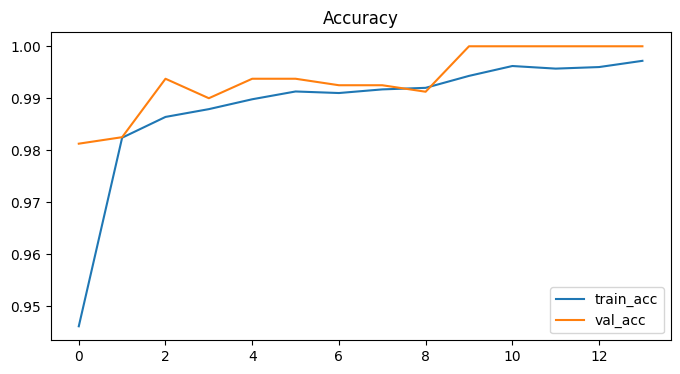

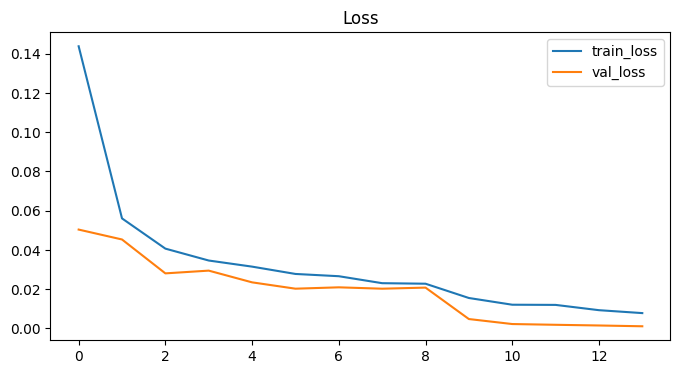

In [14]:
import matplotlib.pyplot as plt

acc = history1.history['accuracy'] + history2.history['accuracy']
val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
loss = history1.history['loss'] + history2.history['loss']
val_loss = history1.history['val_loss'] + history2.history['val_loss']

plt.figure(figsize=(8,4))
plt.plot(acc, label='train_acc')
plt.plot(val_acc, label='val_acc')
plt.legend()
plt.title('Accuracy')
plt.show()

plt.figure(figsize=(8,4))
plt.plot(loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.legend()
plt.title('Loss')
plt.show()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step
              precision    recall  f1-score   support

    WithMask       1.00      1.00      1.00       483
 WithoutMask       1.00      1.00      1.00       509

    accuracy                           1.00       992
   macro avg       1.00      1.00      1.00       992
weighted avg       1.00      1.00      1.00       992



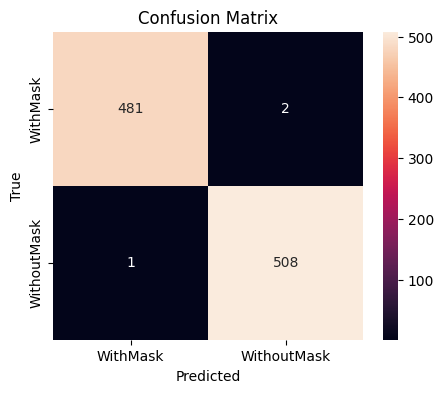

In [16]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

test_generator.reset()
preds = model.predict(test_generator, verbose=1)
y_pred = (preds > 0.5).astype(int).ravel()
y_true = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

test_generator.reset()
x_batch, y_batch = next(test_generator)
preds_batch = model.predict(x_batch)
pred_labels = (preds_batch > 0.5).astype(int).ravel()

plt.figure(figsize=(12,8))
for i in range(min(8, x_batch.shape[0])):
    plt.subplot(2,4,i+1)
    img = x_batch[i]
    plt.imshow(img)  
    pred_label = class_labels[pred_labels[i]]
    true_label = class_labels[int(y_batch[i])]
    title = f"pred: {pred_label}\ntrue: {true_label}"
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step


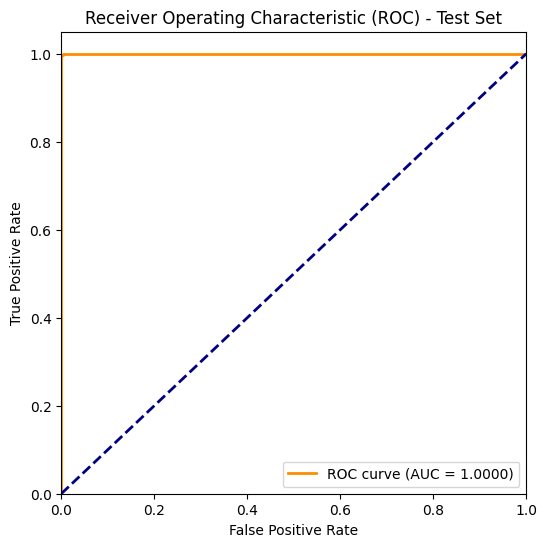

In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

test_generator.reset()
preds = model.predict(test_generator, verbose=1)
y_true = test_generator.classes

fpr, tpr, thresholds = roc_curve(y_true, preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) - Test Set")
plt.legend(loc="lower right")
plt.show()
